In [ ]:
#https://drive.google.com/drive/folders/14CGqlh9ppVGAhvfM85q5otsOs-LkvyPo?usp=share_link

In [ ]:
#!unzip './25_BabyProducts.zip' -d './25_BabyProducts'
!unzip './final_dataset.csv.zip' -d './data'

Archive:  ./final_dataset.csv.zip
  inflating: ./final_dataset.csv/final_dataset.csv  
  inflating: ./final_dataset.csv/__MACOSX/._final_dataset.csv  


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import json
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim.models import FastText
from nltk.stem.porter import *

In [ ]:
folder_path = './25_BabyProducts'
rating_df = pd.read_csv(folder_path+'/ratings_Baby.csv', header=None)
rating_df.columns = ['user','item','rating','timestamp']
rating_df['timestamp'] = ((rating_df['timestamp']/(86400))/365)+1970 #number of years from 1970 plus the year timestamps start from

In [ ]:
rating_df.describe()

,rating,timestamp
count,915446.000000,915446.000000
mean,4.117695,2012.374793
std,1.289458,2.309777
min,1.000000,2000.610959
25%,4.000000,2011.597260
50%,5.000000,2013.180822
75%,5.000000,2013.958904
max,5.000000,2014.586301


In [ ]:
rating_df.head(3)

,user,item,rating,timestamp
0,A28O3NP6WR5517,0188399313,5.0,2013.430137
1,AX0M1Z6ZWO52J,0188399399,5.0,2013.298630
2,A1KD7N84L7NIUT,0188399518,4.0,2014.150685


In [ ]:
#rating_df[rating_df["ser"] == 'A28O3NP6WR5517']
len(set(rating_df["item"].values))

64426

In [ ]:
q_low = rating_df["timestamp"].quantile(0.01)
q_hi  = rating_df["timestamp"].quantile(0.99) 

sum(rating_df[(rating_df["timestamp"] > q_hi) & (rating_df["timestamp"] < q_low)].values)

0

In [ ]:
with open('./25_BabyProducts/meta_Baby.json') as file:
    lines = file.read().splitlines()
df_inter = pd.DataFrame(lines)
df_inter.columns = ['json_element']

In [ ]:
df_inter.values[0]

array(["{'asin': '0188399313', 'categories': [['Baby']], 'description': 'Wee-Go Glass baby bottles by LifeFactory (Babylife) are designed to grow with your child. The included clear cover can also serve as an easy to hold cup. Twist on the solid cap (sold separately) and use your bottles for storing juice or snacks. Perfect for a lunchbox or traveling. The bright colored silicone sleeve (patent pending) helps to protect the bottle from breakage and provides a great gripping surface and tactile experience during feeding. The bottle and sleeve can be boiled or put in the dishwasher together. They can also go in the freezer, making breast milk storage simple.', 'title': 'Lifefactory 4oz BPA Free Glass Baby Bottles - 4-pack-raspberry and Lilac', 'price': 69.99, 'imUrl': 'http://ecx.images-amazon.com/images/I/41SwthpdD9L._SX300_.jpg', 'brand': 'Lifefactory', 'related': {'also_bought': ['B002SG7K7A', 'B003CJSXW8', 'B004PW4186', 'B002O3JH9Q', 'B002O3NLIO', 'B004HGSU28'], 'also_viewed': ['B003

In [ ]:
columns_new = ['asin', 'categories', 'description', 'title', 'price', 'imUrl', 'brand', "also_bought", "also_viewed", 'bought_together', 'buy_after_viewing']

In [ ]:
df_inter.values[0]

array(["{'asin': '0188399313', 'categories': [['Baby']], 'description': 'Wee-Go Glass baby bottles by LifeFactory (Babylife) are designed to grow with your child. The included clear cover can also serve as an easy to hold cup. Twist on the solid cap (sold separately) and use your bottles for storing juice or snacks. Perfect for a lunchbox or traveling. The bright colored silicone sleeve (patent pending) helps to protect the bottle from breakage and provides a great gripping surface and tactile experience during feeding. The bottle and sleeve can be boiled or put in the dishwasher together. They can also go in the freezer, making breast milk storage simple.', 'title': 'Lifefactory 4oz BPA Free Glass Baby Bottles - 4-pack-raspberry and Lilac', 'price': 69.99, 'imUrl': 'http://ecx.images-amazon.com/images/I/41SwthpdD9L._SX300_.jpg', 'brand': 'Lifefactory', 'related': {'also_bought': ['B002SG7K7A', 'B003CJSXW8', 'B004PW4186', 'B002O3JH9Q', 'B002O3NLIO', 'B004HGSU28'], 'also_viewed': ['B003

In [ ]:
meta_df = pd.DataFrame(columns=columns_new)

for json_obj in df_inter.values:

  data = {}

  original_string = json_obj[0]
  evaluated_value = eval(original_string)
  json_obj = json.dumps(evaluated_value)
  json_obj = json.loads(json_obj)

  k = json_obj.keys()

  data['asin'] = json_obj['asin'] if 'asin' in k else None
  data['categories'] = json_obj['categories'][0] if 'categories' in k else None 
  data['description'] = json_obj['description'] if 'description' in k else None
  data['title'] = json_obj['title'] if 'title' in k else None
  data['price'] = json_obj['price'] if 'price' in k else None 
  data['imUrl'] = json_obj['imUrl'] if 'imUrl' in k else None 
  data['brand'] = json_obj['brand'] if 'brand' in k else None 
  
  if 'related' in k:
    related_dict = json_obj['related']
    k = related_dict.keys()

    data['also_bought'] = [related_dict['also_bought']] if 'also_bought' in k else [None]
    data['also_viewed'] = [related_dict['also_viewed']] if 'also_viewed' in k else [None]
    data['bought_together'] = [related_dict['bought_together']] if 'bought_together' in k else [None]
    data['buy_after_viewing'] = [related_dict['buy_after_viewing']] if 'buy_after_viewing' in k else [None]

  else:
    data['also_bought'] = [None]
    data['also_viewed'] = [None]
    data['bought_together'] = [None]
    data['buy_after_viewing'] = [None]

  meta_df = pd.concat([meta_df, pd.DataFrame(data)])


In [ ]:
meta_df.to_csv('meta_baby_dataset.csv')

In [ ]:
meta_df.head(10)

,asin,categories,description,title,price,imUrl,brand,also_bought,also_viewed,bought_together,buy_after_viewing
0,0188399313,Baby,Wee-Go Glass baby bottles by LifeFactory (Baby...,Lifefactory 4oz BPA Free Glass Baby Bottles - ...,69.99,http://ecx.images-amazon.com/images/I/41Swthpd...,Lifefactory,"[B002SG7K7A, B003CJSXW8, B004PW4186, B002O3JH9...","[B003CJSXW8, B0052QOL1Q, B004PW4186, B00EN0OLZ...","[B002SG7K7A, B003CJSXW8]","[B003CJSXW8, B0052QOL1Q, B004PW4186, B002SG7K7A]"
0,0188399518,Baby,The Planet Wise Flannel Wipes are 10 super sof...,Planetwise Flannel Wipes,15.95,http://ecx.images-amazon.com/images/I/41otjnA4...,Planet Wise,"[B00G96N3YY, B003XSEV2O, B000138GNY, B005WWIE3...","[B000138GNY, B00G96N3YY, B006J2U4T0, B00GLBR3C...","[B00G96N3YY, B003XSEV2O]","[B000138GNY, B006J2U4T0, B00G96N3YY, B005WWIMGA]"
0,0188399399,Baby,The Planet Wise Wipe PouchTM features our pate...,Planetwise Wipe Pouch,10.95,http://ecx.images-amazon.com/images/I/61x8h9u6...,None,"[B005WWI0DA, B005WWIMGA, B006J2U4T0, B000138GN...","[B005WWIMGA, B00G96N3YY, B00DAI76TC, B0067GKHV...",None,"[B005WWIMGA, B00G96N3YY, B00DAI76TC, B0067GKHVS]"
0,0316967297,Baby,Hand crafted set includes 1 full quilt (76x86 ...,Annas Dream Full Quilt with 2 Shams,109.95,http://ecx.images-amazon.com/images/I/51%2BZ1%...,None,None,"[B009LTER3W, B00575TI5Q, B004NSYYJI]",None,"[B009LTER3W, B001MX5EE6, B00575TI5Q, B0029009TG]"
0,0615447279,Baby,Thumbuddy To Love- The Binky Fairy helps child...,Stop Pacifier Sucking without tears with Thumb...,16.95,http://ecx.images-amazon.com/images/I/51RKKENl...,,"[0979670004, 1601310234, B005G172KE, 157542257...","[0979670004, 1575422573, 1493535943, 061527364...",[B005G172KE],"[0979670004, 1575422573, B005G172KE, 1493535943]"
0,0670062049,Baby,A baby can be put at risk with an unsafe pacif...,5 Pink Gumdrops + One Pacifier Clip,9.99,http://ecx.images-amazon.com/images/I/41u7qILN...,None,None,"[B005QPE0W8, B00AZWDLHM, B004IOHN8Q, B002GOHLV...",None,"[B005QPE0W8, B00AZWDLHM, B004323NHS, B00GL6CT7E]"
0,0705391752,Baby,Overview\n\nInclude the beloved Peter Rabbit i...,A Tale of Baby's Days with Peter Rabbit,65.07,http://ecx.images-amazon.com/images/I/51%2BNFd...,None,None,"[B001AL7GOQ, 0723256837, 0723262845, B001ET7NE...",[0723256837],"[B001AL7GOQ, 0723256837, 0723262845, B00AYZFGZA]"
0,097293751X,Baby,Easily keep track of your baby's or child's da...,"Baby Tracker&reg; - Daily Childcare Journal, S...",17.00,http://ecx.images-amazon.com/images/I/41Bb6wf%...,Time Too,"[9729375011, B004FN1AE8, B000V5KPZ4, B001F8TLL...","[9729375011, B004FN1ACK, 0976779803, B00K1FNSF...","[9729375011, B001F8TLLU]","[9729375011, B001F8TLLU, B004FN1ACK, 0976779803]"
0,0974671517,Baby,What should we call the Twins? uses an amusing...,Wee Gallery Twins Board Book,3.58,http://ecx.images-amazon.com/images/I/51lCiAJW...,Wee Gallery,"[0670013102, 0763637025, 1442430265, 068984494...","[0670013102, B000KN2YOM, B004U8XBFO, 052542028...","[0670013102, 0763637025]","[0670013102, B004U8XBFO, B000KN2YOM, 0525420282]"
0,0980027519,Baby,"These adorable, high quality calendars are gen...",Nature's Lullabies First and Second Year Calen...,NaN,http://ecx.images-amazon.com/images/I/41NAMKmS...,None,None,None,None,None


In [ ]:
len(rating_df['item'])

915446

In [ ]:
len(set(rating_df['item']))

64426

In [ ]:
len(meta_df['asin'])

71317

In [ ]:
len(set(meta_df['asin']))

71317

In [ ]:
len(meta_df[meta_df['categories'] == 'Baby']) #we can drop it

71317

In [ ]:
meta_df.rename(columns={"asin": "item"}, inplace=True)
inner_merged = pd.merge(rating_df, meta_df)
inner_merged

,user,item,rating,timestamp,categories,description,title,price,imUrl,brand,also_bought,also_viewed,bought_together,buy_after_viewing
0,A28O3NP6WR5517,0188399313,5.0,2013.430137,Baby,Wee-Go Glass baby bottles by LifeFactory (Baby...,Lifefactory 4oz BPA Free Glass Baby Bottles - ...,69.99,http://ecx.images-amazon.com/images/I/41Swthpd...,Lifefactory,"[B002SG7K7A, B003CJSXW8, B004PW4186, B002O3JH9...","[B003CJSXW8, B0052QOL1Q, B004PW4186, B00EN0OLZ...","[B002SG7K7A, B003CJSXW8]","[B003CJSXW8, B0052QOL1Q, B004PW4186, B002SG7K7A]"
1,AX0M1Z6ZWO52J,0188399399,5.0,2013.298630,Baby,The Planet Wise Wipe PouchTM features our pate...,Planetwise Wipe Pouch,10.95,http://ecx.images-amazon.com/images/I/61x8h9u6...,None,"[B005WWI0DA, B005WWIMGA, B006J2U4T0, B000138GN...","[B005WWIMGA, B00G96N3YY, B00DAI76TC, B0067GKHV...",None,"[B005WWIMGA, B00G96N3YY, B00DAI76TC, B0067GKHVS]"
2,A1KD7N84L7NIUT,0188399518,4.0,2014.150685,Baby,The Planet Wise Flannel Wipes are 10 super sof...,Planetwise Flannel Wipes,15.95,http://ecx.images-amazon.com/images/I/41otjnA4...,Planet Wise,"[B00G96N3YY, B003XSEV2O, B000138GNY, B005WWIE3...","[B000138GNY, B00G96N3YY, B006J2U4T0, B00GLBR3C...","[B00G96N3YY, B003XSEV2O]","[B000138GNY, B006J2U4T0, B00G96N3YY, B005WWIMGA]"
3,A29CUDEIF4X1UO,0188399518,3.0,2013.545205,Baby,The Planet Wise Flannel Wipes are 10 super sof...,Planetwise Flannel Wipes,15.95,http://ecx.images-amazon.com/images/I/41otjnA4...,Planet Wise,"[B00G96N3YY, B003XSEV2O, B000138GNY, B005WWIE3...","[B000138GNY, B00G96N3YY, B006J2U4T0, B00GLBR3C...","[B00G96N3YY, B003XSEV2O]","[B000138GNY, B006J2U4T0, B00G96N3YY, B005WWIMGA]"
4,A32592TYN6C9EM,0316967297,4.0,2013.709589,Baby,Hand crafted set includes 1 full quilt (76x86 ...,Annas Dream Full Quilt with 2 Shams,109.95,http://ecx.images-amazon.com/images/I/51%2BZ1%...,None,None,"[B009LTER3W, B00575TI5Q, B004NSYYJI]",None,"[B009LTER3W, B001MX5EE6, B00575TI5Q, B0029009TG]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915441,A3U7438NXFL16A,B00M08188I,5.0,2014.583562,Baby,EasyGoPro Ergonomic Toilet Footrest70 Day Mone...,easyGopro Ergonomic Toilet Footrest for Easier...,21.99,http://ecx.images-amazon.com/images/I/31LgOaDu...,None,None,"[B008G9B11E, B00G5PTWT4, B00HZQO8LE, B007BISCT...",None,None
915442,A1K0FYAEF3H0UP,B00M08188I,5.0,2014.583562,Baby,EasyGoPro Ergonomic Toilet Footrest70 Day Mone...,easyGopro Ergonomic Toilet Footrest for Easier...,21.99,http://ecx.images-amazon.com/images/I/31LgOaDu...,None,None,"[B008G9B11E, B00G5PTWT4, B00HZQO8LE, B007BISCT...",None,None
915443,A25DMFZ9UR90S6,B00M08188I,5.0,2014.583562,Baby,EasyGoPro Ergonomic Toilet Footrest70 Day Mone...,easyGopro Ergonomic Toilet Footrest for Easier...,21.99,http://ecx.images-amazon.com/images/I/31LgOaDu...,None,None,"[B008G9B11E, B00G5PTWT4, B00HZQO8LE, B007BISCT...",None,None
915444,AVH3CQ9L55WW0,B00M08188I,5.0,2014.583562,Baby,EasyGoPro Ergonomic Toilet Footrest70 Day Mone...,easyGopro Ergonomic Toilet Footrest for Easier...,21.99,http://ecx.images-amazon.com/images/I/31LgOaDu...,None,None,"[B008G9B11E, B00G5PTWT4, B00HZQO8LE, B007BISCT...",None,None


In [ ]:
#inner_merged.to_csv('final_dataset.csv')

In [94]:
final_dataset = pd.read_csv('./data/final_dataset.csv', index_col=[0])

In [95]:
final_dataset.columns

Index(['user', 'item', 'rating', 'timestamp', 'categories', 'description',
       'title', 'price', 'imUrl', 'brand', 'also_bought', 'also_viewed',
       'bought_together', 'buy_after_viewing'],
      dtype='object')

In [96]:
final_dataset.head(2)

,user,item,rating,timestamp,categories,description,title,price,imUrl,brand,also_bought,also_viewed,bought_together,buy_after_viewing
0,A28O3NP6WR5517,0188399313,5.0,2013.430137,Baby,Wee-Go Glass baby bottles by LifeFactory (Baby...,Lifefactory 4oz BPA Free Glass Baby Bottles - ...,69.99,http://ecx.images-amazon.com/images/I/41Swthpd...,Lifefactory,"['B002SG7K7A', 'B003CJSXW8', 'B004PW4186', 'B0...","['B003CJSXW8', 'B0052QOL1Q', 'B004PW4186', 'B0...","['B002SG7K7A', 'B003CJSXW8']","['B003CJSXW8', 'B0052QOL1Q', 'B004PW4186', 'B0..."
1,AX0M1Z6ZWO52J,0188399399,5.0,2013.298630,Baby,The Planet Wise Wipe PouchTM features our pate...,Planetwise Wipe Pouch,10.95,http://ecx.images-amazon.com/images/I/61x8h9u6...,NaN,"['B005WWI0DA', 'B005WWIMGA', 'B006J2U4T0', 'B0...","['B005WWIMGA', 'B00G96N3YY', 'B00DAI76TC', 'B0...",NaN,"['B005WWIMGA', 'B00G96N3YY', 'B00DAI76TC', 'B0..."


In [97]:
#final_dataset.drop('index', axis=1, inplace=True)
final_dataset.drop('categories', axis=1, inplace=True)

In [98]:
final_dataset.describe()

,rating,timestamp,price
count,915446.000000,915446.000000,863533.000000
mean,4.117695,2012.374793,50.532528
std,1.289458,2.309777,74.143512
min,1.000000,2000.610959,0.010000
25%,4.000000,2011.597260,11.830000
50%,5.000000,2013.180822,22.990000
75%,5.000000,2013.958904,51.000000
max,5.000000,2014.586301,999.990000


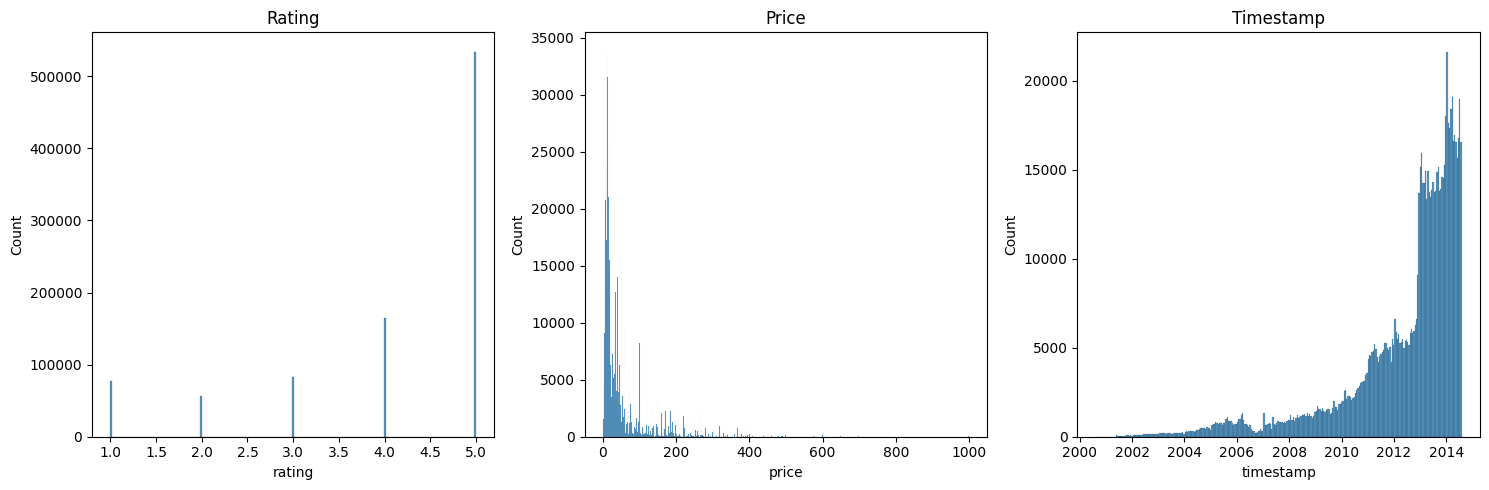

In [99]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(final_dataset['rating'], ax=ax[0])
ax[0].set_title('Rating')

sns.histplot(final_dataset['price'], ax=ax[1])
ax[1].set_title('Price')

sns.histplot(final_dataset['timestamp'], ax=ax[2])
ax[2].set_title('Timestamp')

plt.tight_layout()
plt.show()

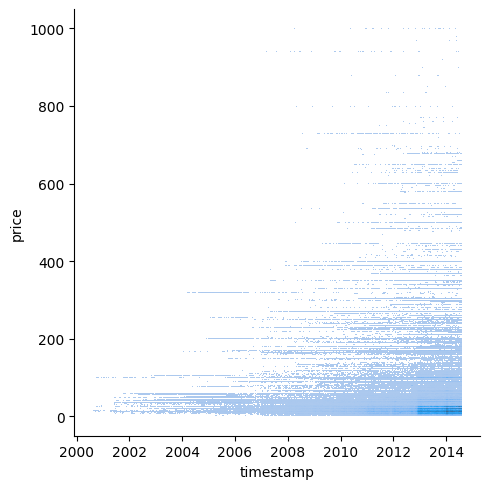

In [100]:
sns.displot(final_dataset, x="timestamp", y="price")
plt.show()

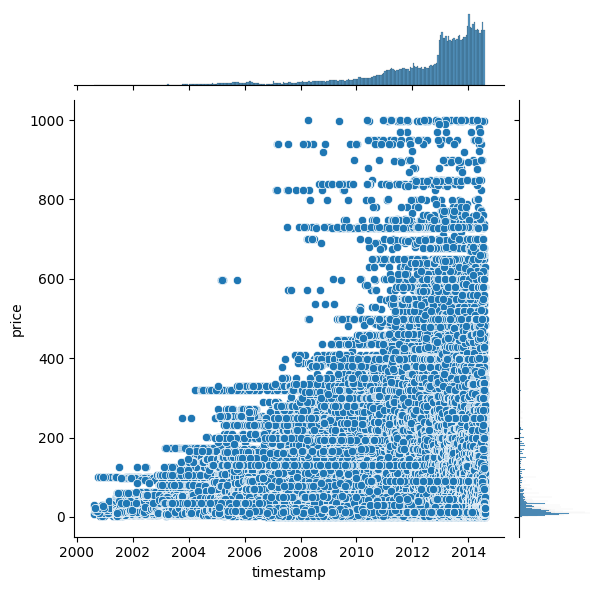

In [101]:
sns.jointplot(data=final_dataset, x="timestamp", y="price")
plt.show()

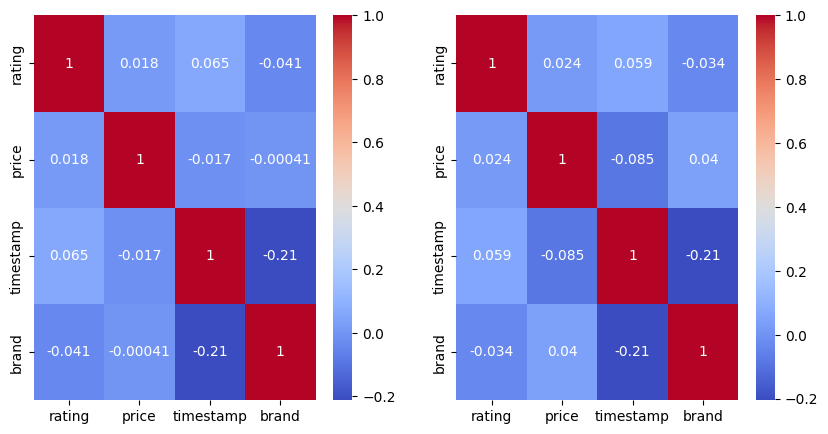

In [102]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# Create a label (category) encoder object
le = LabelEncoder()

# Fit the encoder to the pandas column
le.fit(final_dataset['brand'])

# Transform Categories Into Integers
final_dataset['brand'] = le.transform(final_dataset['brand'])
# Convert 'timestamp' to an integer type
final_dataset['timestamp'] = final_dataset['timestamp'].astype(int)
# Include 'timestamp' in the correlation matrix
correlation_matrix = final_dataset[['rating', 'price', 'timestamp', 'brand']].corr()
# Plot the correlation matrix as a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax=ax[0])
# Show the plot
# Include 'timestamp' in the correlation matrix
correlation_matrix = final_dataset[['rating', 'price', 'timestamp', 'brand']].corr(method='spearman')
# Plot the correlation matrix as a heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', ax=ax[1])
# Show the plot
plt.show()

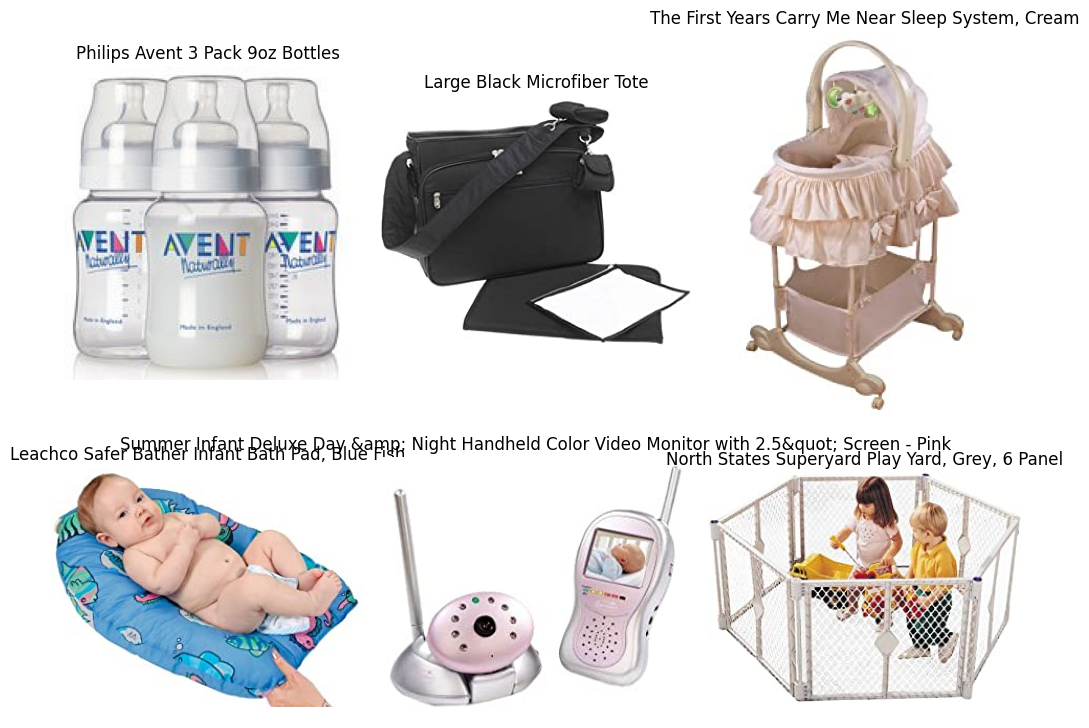

In [103]:
from skimage import io
import random

# Generate 6 unique random indices between 0 and 1,000,000
indices = random.sample(range(0, 100000), 6)

# Adjust the size of the figure
plt.figure(figsize=(10, 8))


# Loop through your list and add each image to the subplot
for i, index in enumerate(indices):
    # Load the image
    f = final_dataset['imUrl'][index]
    t = final_dataset['title'][index]
    a = io.imread(f)
    
    # Add a subplot with image
    plt.subplot(2, 3, i+1)
    plt.imshow(a)
    plt.title(t)
    plt.axis('off')

# Automatically adjust subplot parameters for better layout
plt.tight_layout()
plt.show()

In [104]:
final_dataset.drop('imUrl', axis=1, inplace=True)
print('Nans percentage: ', len(final_dataset[final_dataset.isna().any(axis=1)])/len(final_dataset) * 100, '%')

Nans percentage:  35.07634530054203 %


In [105]:
final_dataset.isna().sum()

user                      0
item                      0
rating                    0
timestamp                 0
description          111987
title                  1493
price                 51913
brand                     0
also_bought          162623
also_viewed           62054
bought_together      214195
buy_after_viewing     55600
dtype: int64

In [106]:
final_dataset.reset_index(inplace=True)
#temp_df

In [ ]:
#we try to fill missing price descritpions and titles by looking at 'duplicates' in the dataset
from tqdm import tqdm
# # for price
dt = final_dataset[['item', 'price']].dropna().drop_duplicates()
# remove duplicate
nan_items = final_dataset[final_dataset['price'].isnull()]['item']

for i in tqdm(nan_items.index):
  corresponding_item = dt[dt['item'] == nan_items.loc[i]]
  if len(corresponding_item) <= 0: 
    continue
  else:
    final_dataset.loc[i, 'price'] = corresponding_item['price'].values[0]


# # for title
dt = final_dataset[['item', 'title']].dropna().drop_duplicates()
# remove duplicate
nan_items = final_dataset[final_dataset['title'].isnull()]['item']

for i in tqdm(nan_items.index):
  corresponding_item = dt[dt['item'] == nan_items.loc[i]]
  if len(corresponding_item) <= 0: 
    continue
  else:
    final_dataset.loc[i, 'title'] = corresponding_item['title'].values[0]


# # for description
dt = final_dataset[['item', 'description']].dropna().drop_duplicates()
# remove duplicate
nan_items = final_dataset[final_dataset['description'].isnull()]['item']

for i in tqdm(nan_items.index):
  corresponding_item = dt[dt['item'] == nan_items.loc[i]]
  if len(corresponding_item) <= 0: 
    continue
  else:
    final_dataset.loc[i, 'description'] = corresponding_item['description'].values[0]


In [107]:
final_dataset.isna().sum()

index                     0
user                      0
item                      0
rating                    0
timestamp                 0
description          111987
title                  1493
price                 51913
brand                     0
also_bought          162623
also_viewed           62054
bought_together      214195
buy_after_viewing     55600
dtype: int64

In [108]:
final_dataset = final_dataset[final_dataset['price'].notna()]
final_dataset = final_dataset[final_dataset['description'].notna()]

In [109]:
final_dataset.isna().sum()

index                     0
user                      0
item                      0
rating                    0
timestamp                 0
description               0
title                     0
price                     0
brand                     0
also_bought          105723
also_viewed           20885
bought_together      149611
buy_after_viewing      4996
dtype: int64

In [110]:
final_dataset = final_dataset[final_dataset['also_bought'].notna()]
final_dataset = final_dataset[final_dataset['also_viewed'].notna()]
final_dataset = final_dataset[final_dataset['bought_together'].notna()]
final_dataset = final_dataset[final_dataset['buy_after_viewing'].notna()]

In [111]:
final_dataset.isna().sum()

index                0
user                 0
item                 0
rating               0
timestamp            0
description          0
title                0
price                0
brand                0
also_bought          0
also_viewed          0
bought_together      0
buy_after_viewing    0
dtype: int64

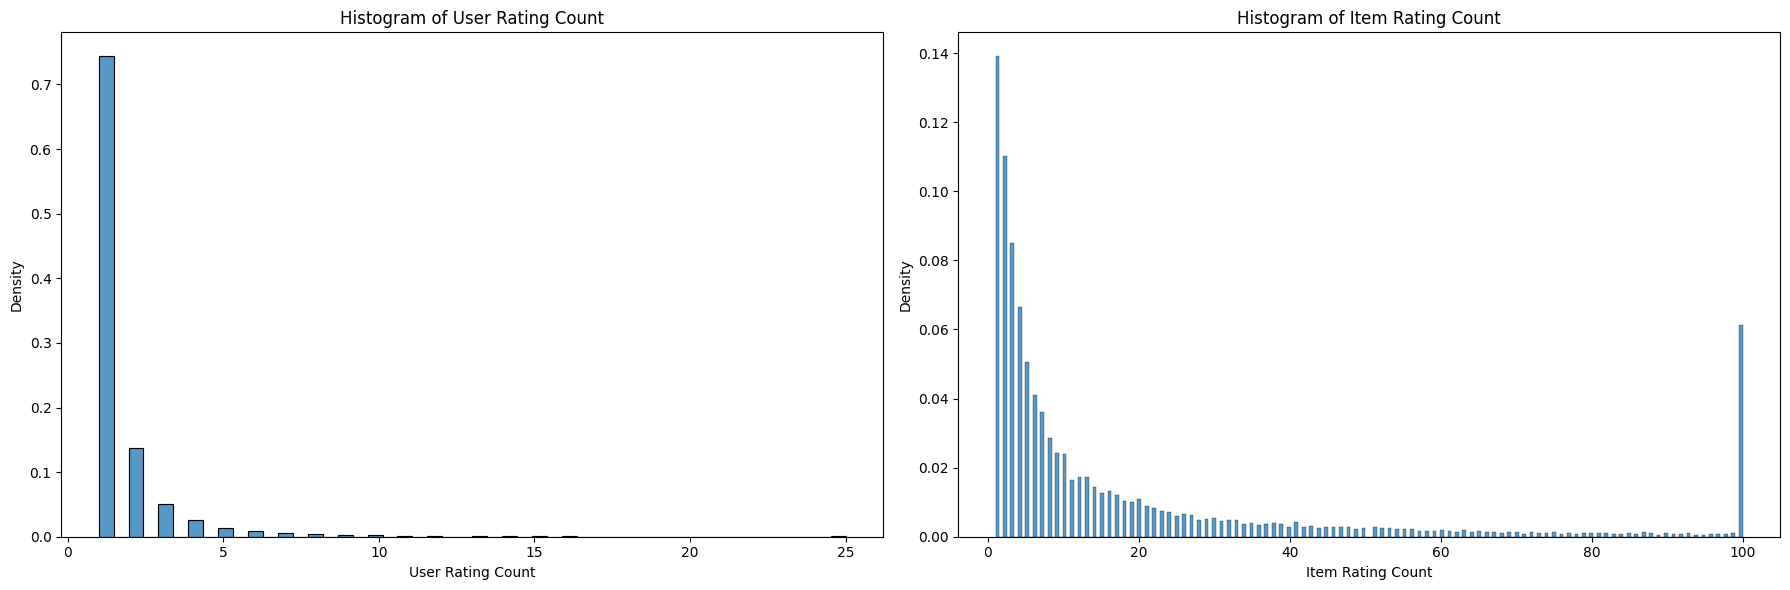

In [112]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6)) # Creates a figure with 1 row and 3 columns of subplots

data2 = final_dataset.groupby('user')['rating'].count().clip(upper=25)
data3 = final_dataset.groupby('item')['rating'].count().clip(upper=100)

sns.histplot(data2, stat='probability', bins=50, kde=False, ax=axs[0])
sns.histplot(data3, stat='probability', bins=200, kde=False, ax=axs[1])


axs[0].set_title('Histogram of User Rating Count')
axs[0].set_xlabel('User Rating Count')
axs[0].set_ylabel('Density')

axs[1].set_title('Histogram of Item Rating Count')
axs[1].set_xlabel('Item Rating Count')
axs[1].set_ylabel('Density')

# Show the plot
plt.tight_layout() 
plt.show()

In [113]:
#FONTE FAKE REVIEW PERCENTAGE
#https://www.fox17online.com/news/local-news/new-study-finds-fake-reviews-cost-consumers-more-money-heres-how-to-spot-them#:~:text=Online%20reviews%20often%20make%20or,them%20as%20fake%20or%20unreliable.

In [114]:
min_user_ratings = 3
temp_df_usr = final_dataset['user'].value_counts() > min_user_ratings
temp_df_usr = temp_df_usr[temp_df_usr].index.tolist()

min_item_ratings = 20 / (1 - 0.42) #to have as expected value of real reviews 50 based on fox reported survey
temp_df_item = final_dataset['item'].value_counts() > min_item_ratings
temp_df_item = temp_df_item[temp_df_item].index.tolist()

print('Original df shape: {}'.format(final_dataset.shape))
final_dataset = final_dataset[(final_dataset['user'].isin(temp_df_usr)) & (final_dataset['item'].isin(temp_df_item))]
print('Modified df shape: {}'.format(final_dataset.shape))

Original df shape: (594341, 13)
Modified df shape: (128171, 13)


# fix related column

In [117]:
def string_to_list(el):
    if type(el) is list:
        return el
    list_el =  el.replace('[','').replace(']','').replace("'",'').split(',')
    return [el.strip() for el in list_el]



In [118]:
memory_usage_mb = final_dataset.memory_usage().sum() / (1024 * 1024)
print("Memory usage: {:.2f} MB".format(memory_usage_mb))

copy_df = final_dataset.copy(deep=True)
# Select all unique items
items = final_dataset['item'].unique().tolist()


# Apply filtering to the 'also_bought' column with tqdm
progress_bar = tqdm(total=len(final_dataset))

def filter_also_bought(x):
    x['also_bought'] = [el for el in string_to_list(x['also_bought']) if el in items]

    x['also_viewed'] = [el for el in string_to_list(x['also_viewed']) if el in items]

    x['bought_together'] = [el for el in string_to_list(x['bought_together']) if el in items]

    x['buy_after_viewing'] = [el for el in string_to_list(x['buy_after_viewing']) if el in items]
    
    progress_bar.update(1)
    return x
i = 1
while True:
    items = final_dataset['item'].unique().tolist()
    # Apply the filtering operation and track progress with tqdm
    final_dataset = final_dataset.apply(filter_also_bought, axis=1)
    # Check if there are any rows with empty lists
    if final_dataset[final_dataset['also_bought'].map(len) == 0].empty \
        and final_dataset[final_dataset['also_viewed'].map(len) == 0].empty \
        and final_dataset[final_dataset['bought_together'].map(len) == 0].empty \
        and final_dataset[final_dataset['buy_after_viewing'].map(len) == 0].empty:
        break
    else:
        print('Iteration: {} found some empty elements'.format(i))
        i += 1
        many_elements = final_dataset[final_dataset['also_bought'].map(len) == 0].shape[0] \
                        + final_dataset[final_dataset['also_viewed'].map(len) == 0].shape[0]  \
                        + final_dataset[final_dataset['bought_together'].map(len) == 0].shape[0] \
                        + final_dataset[final_dataset['buy_after_viewing'].map(len) == 0].shape[0]
        print('Number of empty elements: {}'.format(many_elements))
        # remove the rows with empty lists
        final_dataset = final_dataset[final_dataset['also_bought'].map(len) > 0]
        final_dataset = final_dataset[final_dataset['also_viewed'].map(len) > 0]
        final_dataset = final_dataset[final_dataset['bought_together'].map(len) > 0]
        final_dataset = final_dataset[final_dataset['buy_after_viewing'].map(len) > 0]
        print('New shape: {}'.format(final_dataset.shape))


progress_bar.close()  # Close progress bar
memory_usage_mb = final_dataset.memory_usage().sum() / (1024 * 1024)
print("Memory usage: {:.2f} MB".format(memory_usage_mb))

Memory usage: 7.67 MB


100%|██████████| 128171/128171 [10:36<00:00, 201.23it/s]


Iteration: 1 found some empty elements
Number of empty elements: 25030
New shape: (55248, 13)


Iteration: 2 found some empty elements
Number of empty elements: 4983
New shape: (51804, 13)


Iteration: 3 found some empty elements
Number of empty elements: 671
New shape: (51415, 13)


Iteration: 4 found some empty elements
Number of empty elements: 213
New shape: (51303, 13)


281611it [02:02, 2305.48it/s]

Memory usage: 5.48 MB


In [ ]:
final_dataset.reset_index(inplace=True)
stemmer = PorterStemmer()
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Define the stop words
stop_words = set(stopwords.words('english'))

# Tokenize, stem, and remove stop words
final_dataset['description'] = final_dataset['description'].apply(
    lambda x: ' '.join([stemmer.stem(word) for word in word_tokenize(x) if word not in stop_words])
)

# Tokenize the sentences for FastText
final_dataset['description'] = final_dataset['description'].apply(word_tokenize)

In [121]:
# Tagging each document with unique IDs (index in this case)
tagged_documents = [TaggedDocument(words=desc, tags=[i]) for i, desc in enumerate(final_dataset['description'].tolist())]

# Building a Doc2Vec model
model = Doc2Vec(vector_size=100, window=5, min_count=1, workers=4)

# Build vocab
model.build_vocab(tagged_documents)

# Train Doc2Vec model
model.train(tagged_documents, total_examples=model.corpus_count, epochs=30)

# Get embeddings for each description
final_dataset['description_vector'] = final_dataset['description'].apply(lambda x: model.infer_vector(x))

# Now, 'description_vector' column contains document vectors for each description

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/marziolunghi/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/marziolunghi/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [122]:
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Generate embeddings for each description
description_vectors = np.array([np.mean(desc, axis=0) for desc in final_dataset['description']])

# Use t-SNE to reduce dimensionality to 3D
tsne = TSNE(n_components=3, random_state=42)
embeddings_3d = tsne.fit_transform(description_vectors)

# Indices of points to annotate
idx1, idx2 = 10, 20  # Indices of close points
idx3, idx4 = 30, 40  # Indices of far points

# Plot the result
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2])

# Annotate selected points
ax.text(embeddings_3d[idx1, 0], embeddings_3d[idx1, 1], embeddings_3d[idx1, 2], str(idx1), color='red')
ax.text(embeddings_3d[idx2, 0], embeddings_3d[idx2, 1], embeddings_3d[idx2, 2], str(idx2), color='red')
ax.text(embeddings_3d[idx3, 0], embeddings_3d[idx3, 1], embeddings_3d[idx3, 2], str(idx3), color='blue')
ax.text(embeddings_3d[idx4, 0], embeddings_3d[idx4, 1], embeddings_3d[idx4, 2], str(idx4), color='blue')

plt.show()